<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-LM-data" data-toc-modified-id="Create-LM-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create LM data</a></span></li><li><span><a href="#Create-classifier-data" data-toc-modified-id="Create-classifier-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create classifier data</a></span></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save data</a></span></li></ul></div>

This method allows us to build the LM from all reviews - labeled and unlabeled.

https://docs.fast.ai/tutorial.data.html

# Import libs and define global vars

In [6]:
import os
from fastai.text import * 

# Set the seeds
seedVal = 10
from numpy.random import seed
seed(seedVal)

path = './'
useSubset = False
numSubset = 100

# Load and view data

In [7]:
# Set paths to CSV files
dataPath = os.path.join('.', 'datasets', 'imdb_movie_reviews')
labeledTrainData = os.path.join(dataPath, 'labeledTrainData.tsv')
unlabeledTrainData = os.path.join(dataPath, 'unlabeledTrainData.tsv')
testData = os.path.join(dataPath, 'testData.tsv')

# Read CSV files into DFs
labDat = pd.read_csv(labeledTrainData, sep = '\t', header = 0, quoting = 3)
unlabDat = pd.read_csv(unlabeledTrainData, sep = '\t', header = 0, quoting = 3)
testDat = pd.read_csv(testData, sep = '\t', header = 0, quoting = 3)

# Add columns
labDat['type'] = 'train'
unlabDat['type'] = 'unlabeled'
testDat['type'] = 'test'

unlabDat['sentiment'] = None
testDat['sentiment'] = None


# Sanity check
print('labDat.shape :', labDat.shape)
print('unlabDat.shape :', unlabDat.shape)
print('testDat.shape :', testDat.shape)

# Examine results
print("\n")
print('labDat.info() :', labDat.info())
print("\n")
print('unlabDat.info() :', unlabDat.info())
print("\n")
print('testDat.info() :', testDat.info())

labDat.shape : (25000, 4)
unlabDat.shape : (50000, 4)
testDat.shape : (25000, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
type         25000 non-null object
dtypes: int64(1), object(3)
memory usage: 781.3+ KB
labDat.info() : None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
id           50000 non-null object
review       50000 non-null object
type         50000 non-null object
sentiment    0 non-null object
dtypes: object(4)
memory usage: 1.5+ MB
unlabDat.info() : None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
id           25000 non-null object
review       25000 non-null object
type         25000 non-null object
sentiment    0 non-null object
dtypes: object(4)
memory usage: 781.3+ KB


In [8]:
combinedDat = pd.concat(objs=[labDat, unlabDat, testDat], axis=0).reset_index(drop=True)
print(combinedDat.shape)
print("\n")
print(combinedDat.info())

(100000, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
id           100000 non-null object
review       100000 non-null object
sentiment    25000 non-null object
type         100000 non-null object
dtypes: object(4)
memory usage: 3.1+ MB
None


In [9]:
combinedDat.head()

,id,review,sentiment,type
0,"""5814_8""","""With all this stuff going down at the moment ...",1,train
1,"""2381_9""","""\""The Classic War of the Worlds\"" by Timothy ...",1,train
2,"""7759_3""","""The film starts with a manager (Nicholas Bell...",0,train
3,"""3630_4""","""It must be assumed that those who praised thi...",0,train
4,"""9495_8""","""Superbly trashy and wondrously unpretentious ...",1,train


# Prepare the data

## Create LM data

In [10]:
# Language model data
if useSubset:
    data_lm = (TextList.from_df(df = combinedDat.iloc[:numSubset,:], cols = 'review')
               .random_split_by_pct(seed=seedVal)
               .label_for_lm()
               .databunch())
else:
    data_lm = (TextList.from_df(df = combinedDat[ combinedDat['type'] == 'train'], cols = 'review')
               .random_split_by_pct(seed=seedVal)
               .label_for_lm()
               .databunch())

In [11]:
data_lm.show_batch()

idx,text
0,"xxbos "" i loathed this film . xxmaj the original xxmaj phantasm had such wonderful ambiance and mystery . xxmaj like many 70s horror flicks , it looked and felt like some creepy , unfinished documentary . xxmaj phantasm xxup ii , from the late 80s , pumped up the action , but maintained this nice attention to mood . xxmaj sadly , xxmaj phantasm xxup iii is just awful"
1,"it 's definitely one that he will be remembered for . xxmaj he 's a stubborn old man , not unlike a lot of the old men that you and i probably know . \n\n "" xxmaj the xxmaj straight xxmaj story "" is a movie that everyone should watch at least once in their lives . xxmaj it will reach down and touch some part of you , at"
2,"by all of the cast , even the smallest parts were done with believability . \n\n xxmaj this is not a fast - paced action thriller ; in fact , it moves at times like a slow drama , but it is worth it . xxmaj very satisfying and not exploitative about the crimes at all . \n\n "" xxbos "" xxmaj generally i like horror movies , but unfortunately"
3,"bringing this story to the masses in a way that never demeaned the tragedy . xxmaj the film was made with such humanity . \n\n xxmaj another reviewer said it better than i ever could : xxmaj open up your hearts to xxmaj titanic , and you will not be disappointed . "" xxbos "" xxmaj robert xxmaj siodmak does a fabulous job with this b noir starring xxmaj ella"
4,". ) xxmaj orcs are different matter , since they are meant to look very distinctive from other characters . xxmaj orcs , while played by humans with animation mix , look far superior to xxmaj jacksons version . xxmaj they have brownish - green skin , shiny red eyes , flat face and pointed teeth . \n\n xxmaj biggest screw up in this films visuals , xxunk , are"


## Create classifier data

In [12]:
if useSubset:
    data_clas = (TextList.from_df(df = combinedDat[ combinedDat['type'] == 'train'].iloc[:numSubset,:], cols='review', vocab=data_lm.vocab)
                 .random_split_by_pct(valid_pct=0.1, seed=seedVal)
                 .label_from_df(cols='sentiment')
                 .databunch(bs=32))
else:
    data_clas = (TextList.from_df(df = combinedDat[ combinedDat['type'] == 'train'], cols='review', vocab=data_lm.vocab)
                 .random_split_by_pct(valid_pct=0.1, seed=seedVal)
                 .label_from_df(cols='sentiment')
                 .databunch(bs=32))

In [13]:
print("Train DF size:", len(data_clas.train_ds))
print("Valid DF size:", len(data_clas.valid_ds))

Train DF size: 22500
Valid DF size: 2500


In [14]:
data_clas.show_batch()

text,target
"xxbos "" xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the",1
"xxbos "" xxmaj it has said that xxmaj the xxmaj movies and xxmaj baseball both thrived during xxmaj the xxmaj great xxmaj depression . xxmaj it appears that the grim realities of a xxmaj nation caught up in the aftermath of this xxmaj economic xxmaj disaster created a need for occasional relief for the populace . a temporary escape could be found in the on going soap opera that is",1
"xxbos "" xxup spoilers xxup herein \n\n xxmaj my xxmaj high xxmaj school did all they could to try and motivate us for exams . xxmaj but the most memorable method they used to get us into the right state of mind was a guest speaker , who was none other than xxmaj australian xxmaj kickboxing 's favorite son , xxmaj stan "" xxmaj the xxmaj man "" xxmaj xxunk",0
"xxbos "" i wo n't try to speculate as to what xxmaj brando was attempting . xxmaj at his best he turns in such oddball performances , insinuating so many things at once , that it does n't seem he does anything so much as play by unfailing instinct . xxmaj often it seems he is calling attention to some favored aspect of his character over all others , a",1
"xxbos "" xxup ok xxup ok , it might be hard to put the entirety of a man 's life in one film . xxmaj traditionally therefore , biopics focus on one or two significant parts in the subject 's life . xxmaj now , xxmaj byron was a "" my week beats your year "" fellow , which makes selecting parts that are representative even harder . xxmaj furthermore",0


In [15]:
# How can we view the results of the preprocessing?

# Look at record number three...  The FloatItem at the end is the label
#data_clas.train_ds[2]

#data_clas.train_ds.__class__
# fastai.data_block.LabelList
# https://github.com/fastai/fastai/blob/master/fastai/data_block.py

print(data_clas.train_ds.x[1])
print(data_clas.train_ds.y[1])

#len(data_clas.train_ds.x)
#len(data_clas.valid_ds.x)
#print(len(data_clas.train_ds.x) + len(data_clas.valid_ds.x))
#print(len(labDat))

xxbos " " xxmaj the xxmaj classic xxmaj war of the xxmaj worlds " by xxmaj timothy xxmaj hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate xxup h. xxup g. xxmaj wells ' classic book . xxmaj mr. xxmaj hines succeeds in doing so . i , and those who watched his film with me , appreciated the fact that it was not the standard , predictable xxmaj hollywood fare that comes out every year , e.g. the xxmaj spielberg version with xxmaj tom xxmaj cruise that had only the slightest resemblance to the book . xxmaj obviously , everyone looks for different things in a movie . xxmaj those who envision themselves as amateur " critics " look only to criticize everything they can . xxmaj others rate a movie on more important bases , like being entertained , which is why most people never agree with the " critics " . xxmaj we enjoyed the effort xxmaj mr. xxmaj hines put into being faithful to xxup h.g. xxmaj wells ' classic novel , and we found it to

## Save data

In [16]:
data_lm.save()
data_clas.save()

In [5]:
data_lm = TextLMDataBunch.load(path)
data_clas = TextClasDataBunch.load(path, bs=32)

# Create and fine tune language model

We can use the data_lm object we created earlier to fine-tune a pretrained language model. fast.ai has an English model available that we can download. We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning.

epoch,train_loss,valid_loss,accuracy
1,4.240496,4.009834,0.293506


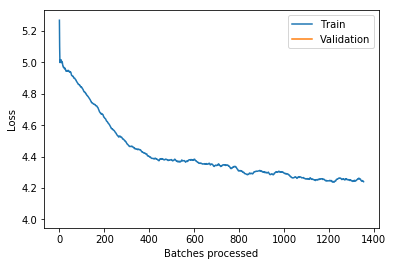

In [18]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)
learn.recorder.plot_losses()

In [19]:
learn.save_encoder('ft_enc')

In [ ]:
# See if this avoids memory issues on the GPU:
torch.cuda.empty_cache()

# Ref:  https://forums.fast.ai/t/clearing-gpu-memory-pytorch/14637/3

---
Next, fine tune the model:

epoch,train_loss,valid_loss,accuracy
1,4.001006,3.908088,0.304922
2,3.896524,3.830257,0.313611
3,3.767224,3.776322,0.319304
4,3.686470,3.748913,0.322630
5,3.623901,3.743937,0.323372


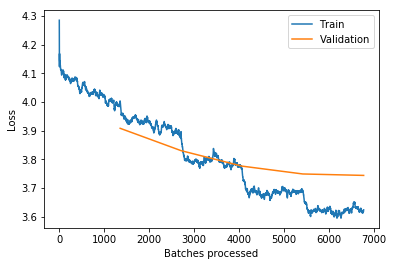

In [20]:
#learn.load_encoder('ft_enc')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)
learn.recorder.plot_losses()

---
Save the encoder for classification in the next section.

In [22]:
learn.save_encoder('ft_enc')

# Build and train the classifier

In [ ]:
learn = text_classifier_learner(data_clas)
learn.load_encoder('ft_enc')

In [ ]:
data_clas.show_batch()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))
learn.recorder.plot_losses()

---

In [ ]:
learn.save('imdb_train_clas')

In [ ]:
learn.show_results(5)

# Predictions

In [ ]:
item = list(combinedDat[ combinedDat['type'] == 'test']['review'])[0]
item

In [ ]:
print(learn.predict(item))
print(int(torch.argmax(learn.predict(item)[2])))

---------------------------------------------------------------------

In [ ]:
data_lm.__class__
method_list = [func for func in dir(data_lm) if callable(getattr(data_lm, func))]
method_list